<h1>I hate myself for attempting this but I'm bored</h1>
<br></br>
<h3>Let me explain myself because I feel this needs explaining:</h3>
<p>Recently, the GPT model has dominated the text-generation realm of AI (as it should, it's fucking amazing). However, I want to see how far I can push the RNN model for text generation before it can't be pushed any further. Of course, conditional text generation has been done before in the past with RNN, and very well, BUT: I am stubborn as fuck and need to experiment by myself to see what I can do. Also I just finished working on a video game and need an overcomplicated project to suck me back into the world of AI. I'll document my findings here in this notebook so you can see the deterioration of my sanity.</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob
from time import sleep

from bs4 import BeautifulSoup as bs4
import requests

DESC_FILE = 'ep_descs.pkl'
TRANS_FILE = 'D:/Machine Learning/Datasets/SpongeBob_SquarePants_Transcripts/'

MAX_SEQ_LEN = 250

<h2>Problem #1: web scraping</h2>
<br></br>
<p>In order to get the generator to generate scripts from a prompt, I need to get descriptions of each episode (which will be the prompts of this generator). Fortunately, this data can be found on the Spongebob Wiki. Unfortunately, this means I have to do some mother-fucking web scraping. I'll try explain what I'm doing with comments but to be honest, I'm going to give up on that pretty quickly. Sorry in advance for my ugly python code</p>
<p>For ease of use later on, I'll store the data (which will be kept in a dictionary) into a seperate file using python's pickle</p>

In [3]:
#running for each season of spongebob
SEASONS = 13
data = {}

for season in range(1, SEASONS+1):
    page = requests.get(f"https://spongebob.fandom.com/wiki/Season_{season}#List_of_episodes").content
    
    soup = bs4(page, 'html.parser')
    table = soup.find_all('table', class_='general')[0]
        
    #let's get the title and descriptions of each episode
    titles = table.find_all('td', style='text-align:left')
    descriptions = table.find_all('td', colspan='4')
    
    for j in range(len(titles)):
        title = titles[j].text
        desc = descriptions[j].text
        #getting rid of the quotation marks around the episode name with possibly the most python line of code ever written (then also do some other pre processing)
        title = title[1:-2]
        title = title.replace(' ', '')
        title = title.lower()
        
        data[title] = desc #updating the dataset
        
#save the compiled data to a file
with open(DESC_FILE, 'wb') as f:
    pickle.dump(data, f)

print("Finished")

Finished


<p>Alright, that wasn't as bad as I thought it would be. I ended up getting the script to work on the third or fourth time. Luckily the spongebob wiki doesn't require javascript to load its shit, so I didn't have to boot up selenium to get this scraper to work. Come to think of it, this was probably the best experience I've had writing a web scraper. Nice</p>

<h1>Problem #2: bringing both datasets together</h1>
<br></br>
<p>Now that I have all the data I need, I need to compile everything into a single dataset that I can use to train the network with. This means for the transcripts, I have to clean, tokenize, and pad everything. For the episode descriptions, I need to combine the descriptions with the correct transcripts.</p>
<p>Some things to consider: RNN models are notoriously bad at generating long sequences of text. Should I set the sampling size lower so that the model performs better? Or should I keep it high so I can really test the limits of this type of model. Hmmmm.... I guess I'll figure it out as I go, but I'm pretty sure I'm going to have to set the sampling size to be smaller. I'll start with the full transcripts and go from there. I think the main reason I want to do this is because I already know how bad LSTM is at performing this task, but I haven't really tested the GRU layer that much and am curious as to how it performs. I think I'll end up training two models.</p>

<h3>Quick side note:</h3>
<p>I want to really quickly go over in text what I want the architecture of the model to be (inputs and outputs for now, I'll go into more detail when I build the model). For starters, the model will have two inputs: X1 and X2. They will store the previous text in the transcript and the prompt, respectively. The output will be a one-hot encoding of the next token to be added to the sequence. My hope with using the two seperate inputs for the model will help it perform better when generating scripts that are more relevant to the provided episode prompt. Again, GPT models handle this problem with ease, but when it comes to RNNs, I want to make sure the model remembers what it should be generating</p>
<p>I'll go with this design for as long as possible, so hopefully I don't lose my shit trying to keep this plan from failing. I have to remember that this is not going to work the first time cuz I have no clue what the fuck I'm doing.</p>

In [4]:
#let's start with the basics: loading the data from disk
dataset = {}

descs = {}
with open(DESC_FILE, 'rb') as f:
    descs = pickle.load(f)

failed_items = 0
successful_items = 0
    
for file in glob.glob(TRANS_FILE + '*.txt'):
    ep_title = file.split('\\')[1].split('.')[0]
    ep_title = ep_title.lower()
    
    #try to access the description of the episode, if it's not on file, just ignore it
    try:
        desc = descs[ep_title]
        
        lines = []
        with open(file, 'r') as f:
            for line in f.readlines():
                lines.append(line.lower())
                #lines.extend('\n')
        
        dataset[desc] = lines
        successful_items += 1
    except:
        failed_items += 1
        continue

print(f"{failed_items} items failed to load")
print(f"{successful_items} items loaded!")

90 items failed to load
303 items loaded!


In [5]:
#alright, now let's process and organize this data (spaghetti code incoming)
print("Processing data...")

pretokenized = []
pretokenizedDescs = []

def tokenize(line):
    #not even going to explain this mess. Just know this cleans the data. Don't currently know a better way of doing this and it's killing me inside. 
    tokens = []
    for word in line.split(' '):
        newword = ""
        for char in word:
            if not char.isalpha():
                if newword != "":
                    tokens.append(newword)
                newword = ""
                tokens.append(char)
            else:
                newword += char
        if(newword!=''):
            tokens.append(newword)
    return tokens

for desc in dataset:
    #clean the data
    tempdata = [x for x in dataset[desc] if x != '\n']
    tokens = []
    descTokens = []
    
    for line in tempdata:
        line += "\n"
        tokens.extend(tokenize(line))
        
    pretokenizedDescs.append(tokenize(desc.lower()))
    #removing unecessary tokens
    pretokenizedDescs[-1].pop(pretokenizedDescs[-1].index('\n'))
    
    pretokenized.append(tokens)
    
#now let's tokenize this sucker and then move on to building the dataset to be fed to the network.
lib = [''] #library of tokens
tokenized = [] #dataset tokenized
tokenizedDescs = [] #same thing but descriptions
maxLen = 0 #for padding later down the road
maxDescLen = 0 #same thing but for descriptions

#first the transcripts (calculating the maximum sequence length and then tokenizing the dataset using the lib array)
for i in pretokenized:
    if len(i) > maxLen:
        maxLen = len(i)
    for j in i:
        if j not in lib:
            lib.append(j)
            
for i in pretokenized:
    temp = []
    for j in i:
        temp.append(lib.index(j))
    tokenized.append(temp)
    
#now the descriptions
for i in pretokenizedDescs:
    if len(i) > maxDescLen:
        maxDescLen = len(i)
    for j in i: #continuing to build upon the library just in case there are some tokens that didn't make the list yet
        if j not in lib:
            lib.append(j)
            
for i in pretokenizedDescs:
    temp = []
    for j in i:
        temp.append(lib.index(j))
    tokenizedDescs.append(temp)
    
#now we need to pad the tokenized descriptions since that won't happen automatically when the dataset it built
for i, n in enumerate(tokenizedDescs):
    for j in range(MAX_SEQ_LEN-len(n)):
        tokenizedDescs[i].append(0) #padding (0 token represents and empty string in the lib array)

print("Finished")

Processing data...
Finished


In [6]:
from tensorflow.keras.utils import to_categorical
import random

#smallest length a sequence can be
MIN_LEN = 5

X1 = [] #ep descriptions
X2 = [] #prev tokens
Y = []  #ep transcipts

#helper to generate random batches of data from the main dataset
#loading the whole dataset to memory at one time on my 16GB of ram would fry my computer pretty quickly. Let's avoid that
def get_dataset(batch_size, size=maxLen):
    X1 = []
    X2 = []
    Y = []
    for batch in range(batch_size):
        rand_trans = random.randrange(MIN_LEN, len(tokenized)) #get a random transcript to get information from
        rand_start = random.randrange(0, min(len(tokenized[rand_trans]), size) - MIN_LEN)
        rand_length = random.randrange(1, (min(len(tokenized[rand_trans]), size)) - rand_start)
        
        temp = tokenized[rand_trans][rand_start:rand_start+rand_length]
        for i in range(size-rand_length):
            temp.append(0)

        X1.append(np.array(temp))
        X2.append(tokenizedDescs[rand_trans])
        Y.append(tokenized[rand_trans][rand_length])
        
    X1 = np.array(X1)
    X2 = np.array(X2)
    Y = np.array(Y)
    
    X1 = np.reshape(X1, (X1.shape[0], X1.shape[1]))
    X2 = np.reshape(X2, (X2.shape[0], X2.shape[1]))
    Y = to_categorical(Y, num_classes=len(lib))
    return X1, X2, Y

<h1>Problem #3: Building the model</h1>
<br></br>
<p>Gettting the data prepped is always the most annoying and difficult part. This time (for me at least) was no exception. I spent a good 2 hours writing the above cells, and now I'm ready to move on. Luckily, with everything put into place, it should IN THEORY be easy to set this model up.</p>
<p>I already went over the plan in an above cell, so I won't explain myself again. This is already a stupid idea, I'm just going to roll with it at this point. I'm going to start with one GRU layer for each input layer, and then move on from there depending on how the model performs. I'll make sure to update this cell if I decide to change the model design drastically (which I most likely will do). I also plan on comparing the difference in performance between a LSTM model and a GRU model, so I'll document my findings later down the line. I feel like GRU will perform better, but I'll test both models just to be sure.</p>

In [10]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Embedding, Dense, GRU, LSTM, Dropout, BatchNormalization, concatenate, TimeDistributed, Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

def GRUModel():
    embedding_layer = Embedding(len(lib), 1000, input_length=1)
    
    #transcript input
    x_in = Input(shape=(MAX_SEQ_LEN))
    
    x = embedding_layer(x_in)
    x = GRU(128, return_sequences=True)(x)
    x = LeakyReLU()(x)
    
    x = Model(inputs=x_in, outputs=x)
    
    #description input
    y_in = Input(shape=(MAX_SEQ_LEN))
    
    y = embedding_layer(y_in)
    y = GRU(128, return_sequences=True)(y)
    y = LeakyReLU()(y)
    
    y = Model(inputs=y_in, outputs=y)
    
    #combine
    z = concatenate([x.output, y.output])
    
    z = TimeDistributed(Dense(128))(z)
    z = TimeDistributed(LeakyReLU())(z)
    z = TimeDistributed(Dropout(0.2))(z)
    
    z = Flatten()(z)
    
    z = Dense(len(lib), activation='softmax')(z)
    
    z = Model(inputs=[x_in, y_in], outputs=z)
    return z

def TestModel():
    #transcript input
    x_in = Input(shape=(MAX_SEQ_LEN))
    
    x = Embedding(len(lib), 100, input_length=1)(x_in)
    
    x = GRU(128)(x)
    x = LeakyReLU()(x)
    
    x = Dense(len(lib), activation='softmax')(x)
    
    z = Model(inputs=x_in, outputs=x)
    return z

def LSTMModel():
    #transcript input
    x_in = Input(shape=(MAX_SEQ_LEN))
    
    x = Embedding(len(lib), 20, input_length=1)(x_in)
    x = LSTM(300)(x)
    x = Dropout(0.2)(x)
    
    x = Dense(200)(x)
    x = Dropout(0.15)(x)
    
    x = Model(inputs=x_in, outputs=x)
    
    #description input
    y_in = Input(shape=(maxDescLen))
    
    y = Embedding(len(lib), 20, input_length=1)(y_in)
    y = LSTM(300)(y)
    y = Dropout(0.2)(y)
    
    y = Dense(200)(y)
    y = Dropout(0.2)(y)
    
    y = Model(inputs=y_in, outputs=y)
    
    #combine
    z = concatenate([x.output, y.output])
    
    z = Dense(128, activation='relu')(z)
    
    z = Dense(len(lib), activation='softmax')(z)
    
    z = Model(inputs=[x_in, y_in], outputs=z)
    return z

In [11]:
model = TestModel()

opt = Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 100)          1795000   
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               88320     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 17950)             2315550   
Total params: 4,198,870
Trainable params: 4,198,870
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1000/1000: LOSS=5.273431777954102    ACC=0.0
Finished


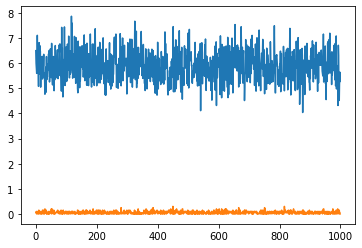

In [13]:
#fitting the model (please god please work please)
from IPython.display import clear_output

epochs = 1000
batch_size = 20

losses = []

for i in range(epochs):
    #generate some data
    X1, X2, Y = get_dataset(batch_size, MAX_SEQ_LEN)

    #train the network
    loss = model.train_on_batch(X1, Y)
    losses.append(loss)
    
    clear_output(wait=True)
    print(f"Epoch {i+1}/{epochs}: LOSS={loss[0]}    ACC={loss[1]}")

print("Finished")
model.save("SpongeBobLSTM.h5")
plt.plot(losses)

<h1>Problem #4: Testing the model</h1>
<br></br>
<p>Now that I have a trainable model, I need a way of testing it's capabilities outside of a graph. My goal is to create a program that takes a prompt, tokenizes and processes the prompt, and then passes it through the model until the model generates a story as big as what it can take as input (if that makes any sense). Hopefully the code should explain itself for this one as I'll be using a lot of the code I already written.</p>

In [43]:
from tqdm.notebook import tqdm as log_progress

#how many tokens to take from the actual dataset 
start_seq_len = 5

prompt = input("Enter prompt for episode: ")
prompt = prompt.lower()

#tokenize the prompt if it's short enough
if len(prompt.split(' ')) < MAX_SEQ_LEN:
    tokens = tokenize(prompt)
    ep_prompt = []
    
    for i in tokens:
        if i in lib:
            ep_prompt.append(lib.index(i))
        else:
            ep_prompt.append(0)
            
    for i in range(MAX_SEQ_LEN-len(ep_prompt)):
        ep_prompt.append(0)
        
    ep_prompt = np.array(ep_prompt)
    ep_prompt = np.reshape(ep_prompt, (1, ep_prompt.shape[0]))
    
    #create a temp array to hold the previous tokens of the generated story
    episode = np.zeros((1, MAX_SEQ_LEN))
    episode[0][0:start_seq_len] = random.choice(tokenized)[0:start_seq_len]
    
    episode[0][0] = random.randrange(0, len(lib)) #start with a random token
    
    counter = start_seq_len
    for i in log_progress(range(MAX_SEQ_LEN-start_seq_len)):
        next_token = model.predict([episode, ep_prompt], verbose=0)
        episode[0][counter] = next_token[0].argmax()
        counter += 1
        
    #finally print the finished story
    episode_script = ''
    for i in episode[0]:
        episode_script += lib[int(i)] + ' '
        
    print(episode_script)
else:
    print("Prompt is too long!")

Enter prompt for episode: spongebob kills his friend


  0%|          | 0/245 [00:00<?, ?it/s]

migger the episode begins with . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


<h2>Some notes:</h2>
<ol>
    <li>Embedding layer might not be that useful. I'm just trying to understand and generate sequences, not get the AI to understand the difference between words.</li>
    <li>If embedding layers are useless, switching to a character based tokenization might be better than the word based tokenization method I'm using now.</li>
    <li>The AI currently does not seem to understand any differences. I've changed the architecture of the model several times with no change in it's performance, so I'm going to guess the problem lies with how I'm feeding and prepping the data.</li>
</ol>
<br></br>
<h3>Performance notes after changing data to character-based tokenization:</h3>